# 삼성전자 첨기연 시각 심화

- **Instructor**: Jiun Bae
- **Email**: [jiun.maydev@gmail.com](mailto:jiun.maydev@gmail.com)

## Object Detection Example

In this example you will practice a simple object detection network written by only [Numpy](https://www.numpy.org) which is fundamental package for scientific computing with Python. The goals of this example are as follows:

- Understand **Object Detection** from classifier and how they work.
- Learn basically how to **write and use code**(*Numpy*).

*If you are more familiar with PyTorch and TensorFlow(or Keras), You might be wondering why to write from the ground up with numpy instead of the built-in framework. This process is essential for understanding how a neural network works, and if you understand it, will not be too difficult to write in code.*

And this example also is written in [IPython Notebook](https://ipython.org/notebook.html), an interactive computational environment, in which you can run code directly.

### Environments

In this assignment, we assume the follows environments. 

The [Python](https://www.python.org) is a programming language that lets you work quickly and integrate systems more effectively. It is widely used in various fields, and also used in machine learning.

The [Pytorch](https://pytorch.org) is an open source deep learning platform, provides a seamless path from research to production.

The [Tensorflow](https://www.tensorflow.org) is an end-to-end open source platform for machine learning. It has a comprehensive, flexible ecosystem of tools, libraries and community resources that lets researchers push the state-of-the-art in ML and developers easily build and deploy ML powered applications.

The [CUDA®](https://developer.nvidia.com/cuda-zone) Toolkit provides high-performance GPU-accelerated computation. In deep learning, the model takes an age to train without GPU-acceleration. ~~even with the GPU, it still takes a lot of time~~.


- [Python3](https://www.python.org/downloads/) (recommend 3.6 or above)
- [PyTorch](https://pytorch.org) (recommend 1.0)
- [Tensorflow](https://tensorflow.org) (recommend above 1.13.0, but under 2.0 *There are huge difference between 2.0 and below*)
- [NumPy](http://www.numpy.org) the fundamental package for scientific computing with Python


- (Optional) [Anaconda](https://www.anaconda.com/distribution/#download-section), *popular Python Data Science Platform*
- (Optional) [Jupyter](https://jupyter.org/) (Notebook or Lab)
- (Optional) [CUDA](https://developer.nvidia.com/cuda-downloads) support GPU


Python packages can install by `pip install [package name]` or using **Anaconda** by `conda install [package name]`.

*If you are having trouble installing or something else, please contact TA or jiun.maydev@gmail.com.*

# Code

### Import packages

Numpy the basic scientific computing package used in customary.

In [1]:
import numpy as np

## Load MNIST dataset

Tesnorflow provide mnist dataset as binary archive file [link](https://chromium.googlesource.com/external/github.com/tensorflow/tensorflow/+/r0.7/tensorflow/g3doc/tutorials/mnist/download/index.md).
In this exampe, we already downloaded datafile in `./data` directory. So just laod dataset from `./data`.

In [2]:
import numpy as np
from tensorflow.python import keras

In [3]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data('mnist.npz')

## Generate Object Detection dataset

We can generate object detection dataset by cutting and pasting MNIST dataset.

In [4]:
np.random.seed(42)

In [5]:
new_images = np.empty((0, 224, 224), dtype=np.float64)
new_labels = []

image_cache, label_cache = np.zeros((224, 224), dtype=np.float64), np.empty((0, 5), dtype=np.uint8)
object_count = np.random.randint(1, 10)

for image, label, _ in zip(train_images, train_labels, range(1000)):
    if not object_count:
        new_images = np.concatenate((new_images, np.expand_dims(image_cache, 0)))
        new_labels.append(label_cache)
        
        image_cache, label_cache = np.zeros((224, 224), dtype=np.float64), np.empty((0, 5), dtype=np.uint8)
        object_count = np.random.randint(1, 10)
    
    x, y = np.random.randint(0, 224-28), np.random.randint(0, 224-28)
    image_cache[y:y+28, x:x+28] = image
    label_cache = np.concatenate((label_cache, np.array([[label, x, y, x+28, y+28]])))
    
    object_count -= 1

## (Optional) Visualize

In [6]:
from PIL import Image
from IPython.display import display

def show(ary):
    display(Image.fromarray(ary))

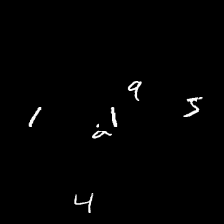

In [7]:
show(new_images[0].astype(np.uint8))

In [8]:
new_labels[0]

array([[  5, 179,  92, 207, 120],
       [  0,  14, 106,  42, 134],
       [  4,  71, 188,  99, 216],
       [  1,  20, 102,  48, 130],
       [  9, 121,  74, 149, 102],
       [  2,  87, 116, 115, 144],
       [  1,  99, 103, 127, 131]])

## Preprocessing

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255. We scale these values to a range of 0 to 1 before feeding to the neural network model. For this, we divide the values by 255. It's important that the training set and the testing set are preprocessed in the same way:

In [9]:
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)

train_images = train_images / 255.
test_images = test_images / 255.

In [10]:
from tensorflow.python.keras.utils import to_categorical
num_classes = 10
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [11]:
new_images = np.expand_dims(new_images, -1)
new_images = new_images / 255.

## Network

This is a simple two dense(fully connected) layer network. The code is quite easy.

So, whole network architecture as follow:

- Dense
- Sigmoid
- Dense
- Sigmoid
- Dense
- Sigmoid

In [12]:
class Layer:
    pass

class Dense(Layer):
    def __init__(self, input_units, output_units):
        self.weights = np.random.randn(output_units, input_units) * .01
        self.biases = np.random.randn(output_units, 1) * .1
        
    def forward(self, inputs):
        self.inputs = inputs
        
        return np.dot(self.weights, inputs) + self.biases
      
    def backward(self, grads):
        size = np.size(grads, -1)

        self.grad_weights = np.dot(grads, self.inputs.T) / size
        self.grad_biases = np.sum(grads, axis=1, keepdims=True) / size

        return np.dot(self.weights.T, grads)

    def update(self, lr: float = .01):
        # Here we perform a stochastic gradient descent step.
        self.weights = self.weights - lr * self.grad_weights
        self.biases = self.biases - lr * self.grad_biases

In [13]:
class Sigmoid(Layer):
    def forward(self, inputs):
        self.inputs = inputs
        return 1. / (1. + np.exp(-inputs))

    def backward(self, grads):
        r = self.forward(self.inputs)
        return grads * r * (1. - r)
    
    def update(self, lr):
        pass

In [14]:
from typing import List
from functools import reduce


def fit(networks: List[Layer], X, y, train=True, epsilon=1e-7):
    X = np.reshape(X, (X.shape[0], -1))
    
    # Forward
    preds = reduce(lambda inputs, layer: layer.forward(inputs), [X.T, *networks]).T
    
    # Compute Loss
    loss = -np.sum(y * np.log(np.clip(preds, epsilon, 1. - epsilon) + epsilon)) / np.size(preds, 0)
    
    if train:
        # Backward
        grads = -(np.divide(y, preds) - np.divide(1 - y, 1 - preds))
        grads = reduce(lambda grads, layer: layer.backward(grads), [grads.T, *reversed(networks)])
    
        # Update
        for layer in networks:
            layer.update(lr)
    
    return loss.mean(), preds

## Prepare

In [15]:
def get_batch(datasets, batch, augmentation=False):
    image, label = None, None
    images, labels = datasets
    for b, (i, l) in enumerate(zip(*datasets)):
        if not (b % batch):
            if image is not None and label is not None:
                yield image, label
            image = np.empty((batch, 28, 28, 1), dtype=np.float32)
            label = np.empty((batch, 10), dtype=np.uint8)
            
        if augmentation:
            ni = np.zeros((28+8, 28+8, 1), dtype=np.float32)
            ni[4:4+28, 4:4+28] = i
            x, y = np.random.randint(0, 8), np.random.randint(0, 8)
            i = ni[y:y+28, x:x+28]
            
        image[b % batch] = i
        label[b % batch] = l

In [16]:
np.random.seed(42)

In [17]:
lr = .1
batch = 128
epochs = 32

In [18]:
network = [
    Dense(28*28, 100),
    Sigmoid(),
    Dense(100, 200),
    Sigmoid(),
    Dense(200, 10),
    Sigmoid(),
]

## Train

In [19]:
for epoch in range(epochs):
    # Train scope
    train_loss, test_loss, test_acc = 0, 0, 0
    for images, labels in get_batch((train_images, train_labels), batch, True):
        loss, _ = fit(network, images, labels)
        train_loss += loss
        
    for images, labels in get_batch((test_images, test_labels), batch):
        loss, preds = fit(network, images, labels, train=False)

        test_loss += loss
        test_acc += (preds.argmax(axis=-1) == labels.argmax(axis=-1)).mean()
        
    if not (epoch % 4):
        print(f'Epoch: {epoch}')
        print(f'\tTrain Loss: {train_loss / (len(train_images) / batch)}')
        print(f'\tTest Loss: {test_loss / (len(test_images) / batch)}')
        print(f'\tTest Acc: {test_acc / (len(test_images) / batch)}')

Epoch: 0
	Train Loss: 2.3018851758674184
	Test Loss: 2.2983367595717237
	Test Acc: 0.103
Epoch: 4
	Train Loss: 2.3038526319393213
	Test Loss: 2.297792454463982
	Test Acc: 0.103
Epoch: 8
	Train Loss: 2.3002946397841284
	Test Loss: 2.2914860591498187
	Test Acc: 0.229
Epoch: 12
	Train Loss: 2.0343977224347727
	Test Loss: 1.9479931660201038
	Test Acc: 0.2654
Epoch: 16
	Train Loss: 1.804199476979271
	Test Loss: 1.6057418031830868
	Test Acc: 0.4311
Epoch: 20
	Train Loss: 1.4485304421065437
	Test Loss: 1.2531526262341088
	Test Acc: 0.624
Epoch: 24
	Train Loss: 1.1316912158465608
	Test Loss: 1.0066167139064532
	Test Acc: 0.7439
Epoch: 28
	Train Loss: 0.8759451393551604
	Test Loss: 0.7928198934910634
	Test Acc: 0.8164


## Test

In [20]:
for image, label, _ in zip(test_images, test_labels, range(10)):
    show((image[:, :, 0] * 255.).astype(np.uint8))
    prediction = reduce(lambda inputs, layer: layer.forward(inputs), [np.reshape(np.array(image), -1)[None, :].T, *network])
    print (f'Label: {label.argmax(-1)}, Prediction: {prediction.argmax()}')

Label: 7, Prediction: 7


Label: 2, Prediction: 2


Label: 1, Prediction: 1


Label: 0, Prediction: 0


Label: 4, Prediction: 4


Label: 1, Prediction: 1


Label: 4, Prediction: 4


Label: 9, Prediction: 9


Label: 5, Prediction: 6


Label: 9, Prediction: 9


## Detecting object (with brute force)

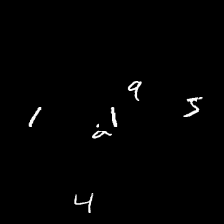

1


1


1


1


7


2


0


2


7


2


2


1


0


1


3


1


3


0


2


7


1


2


9


3


0


1


7


1


3


1


7


2


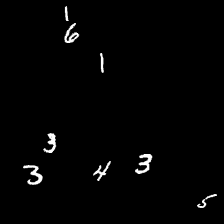

2


2


0


2


0


2


6


3


3


2


7


7


0


0


6


3


7


3


2


0


3


2


6


3


7


2


7


7


0


7


1


2


1


4


1


1


0


1


2


2


7


3


2


0


1


4


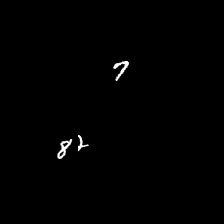

2


7


2


3


1


4


1


2


2


In [21]:
for image, label, _ in zip(new_images, new_labels, range(3)):
    show((image[:, :, 0]*255.).astype(np.uint8))
    
    for x in range(int(224/8)):
        for y in range(int(224/8)):
            crop = image[y*8:y*8+28, x*8:x*8+28, :]
            if crop.shape != (28, 28, 1):
                continue
            prediction = reduce(lambda inputs, layer: layer.forward(inputs), [np.reshape(np.array(crop), -1)[None, :].T, *network])
            score = (prediction.max() ** 2 - prediction.mean() ** 2) ** .5
            if score > .6 and score < .9:
                show((crop[:, :, 0]*255.).astype(np.uint8))
                print(prediction.argmax())

In [22]:
from skimage.feature import hog

In [23]:
new_image = new_images[0]

In [24]:
fd, hog_image = hog((new_image * 255.).astype(np.uint8), orientations=8, pixels_per_cell=(4, 4),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

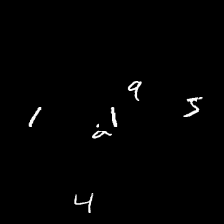

In [25]:
show((new_image[:, :, 0] * 255.).astype(np.uint8))

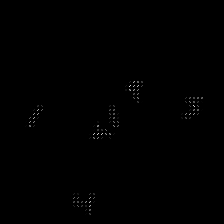

In [26]:
show((hog_image).astype(np.uint8))

In [27]:
proposals = np.empty((0, 28, 28), dtype=np.float64)

for x in range(int(224/8)):
    for y in range(int(224/8)):
        crop = hog_image[y*8:y*8+28, x*8:x*8+28]
        if crop.shape != (28, 28):
            continue
            
        if crop.mean() > 5.:
            proposals = np.concatenate((proposals, np.expand_dims(new_image[y*8:y*8+28, x*8:x*8+28, 0], 0)))

In [28]:
for proposal in proposals:
    prediction = reduce(lambda inputs, layer: layer.forward(inputs), [np.reshape(np.array(proposal), -1)[None, :].T, *network])
    score = (prediction.max() ** 2 - prediction.mean() ** 2) ** .5
    show((proposal*255.).astype(np.uint8))
    print(prediction.argmax())

0


4


4


0


6


3


3


6


7


0


9


3


7


0


3


3


5


2
